In [ ]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine,cdist

from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler



#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
%reload_ext utils
%reload_ext modeling

%matplotlib inline
%load_ext autoreload
%autoreload 2

try:
    remote_server="http://ec2-18-184-134-25.eu-central-1.compute.amazonaws.com"
    client = MlflowClient(remote_server)
    mlflow.set_tracking_uri(remote_server)
except ConnectionError as ConnErr:
    print("Could not reach remote MLflow service")
    client = MlflowClient()
    mlflow.set_experiment("Windowed Clustering")


In [ ]:
df= utils.load_text_data("../data/2k_22-10.csv").head(2000)


In [ ]:
total = 240
overlap_ratio = 0.8
#df_a,df_b = df.head(total).sample(round(total*overlap_ratio)),df.head(total).sample(round(total*overlap_ratio))
df_a = df[(df.created_at.dt.day >= 20) & (df.created_at.dt.day <= 21)].sample(frac=0.7)
df_b = df[(df.created_at.dt.day >= 21) & (df.created_at.dt.day <= 22)].sample(frac=0.7)
sets = [set(df_a.index.values), set(df_b.index.values)]
venn2(sets)
print()

In [ ]:
pdf_a = utils.preprocess_articles_for_bert(df_a,lower=True)
pdf_b = utils.preprocess_articles_for_bert(df_b,lower=True)

# Instead of spliting the data into two versions of the data just cluster twice the same data and then match them ...
unique_for_a= len(((sets[0] ^ sets[1]) & sets[0]) )
unique_for_b= len(((sets[0] ^ sets[1]) & sets[1]) )
common_for_both = len(sets[0] & sets[1])

In [ ]:
#load BERT model from Hugging Face
#model_name= "T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
model_name= "T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb"
#model_name= "T-Systems-onsite/german-roberta-sentence-transformer-v2"

#word_embedding_model = models.Transformer(model_name)
try:
    pass
    
    
    
except ConnectionError as ConnErr:
    print("Could not reach service")
    

In [ ]:
embeddings_a = modeling.get_sentence_embeddings(pdf_a,word_embedding_model)
embeddings_b = modeling.get_sentence_embeddings(pdf_b,word_embedding_model)

In [257]:
N_COMPONENTS=128
alpha=0.7925
min_cluster_size=3
min_samples=3
n_neighbors=7

uamp_a, clusters_a = modeling.cluster_and_reduce(embeddings_a,n_components_clustering=N_COMPONENTS, min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                             min_samples= min_samples,alpha=alpha)

uamp_b, clusters_b = modeling.cluster_and_reduce(embeddings_b,n_components_clustering=N_COMPONENTS,min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                             min_samples= min_samples,alpha=alpha)

In [258]:
docs_df_a = utils.relink_data_after_clustering(uamp_a,df_a,clusters_a)
docs_df_b = utils.relink_data_after_clustering(uamp_b,df_b,clusters_b)


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_a_per_topic = docs_df_a.groupby(['topic_number'], as_index = False).agg({'raw_text': ' '.join,
                                                                   'headline': '. '.join,
                                                                    "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                        "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ]))

                                                                  }).set_index("topic_number")


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_b_per_topic = docs_df_b.groupby(['topic_number'], as_index = False).agg({'raw_text': ' '.join,
                                                                   'headline': '. '.join,
                                                                    
                                                                    "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                     "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ]))
                                                                  }).set_index("topic_number")



Outliers: 31 | Clustered: 266 | 0.8956228956228957 
 Cluster count: 43 
Outliers: 16 | Clustered: 260 | 0.9420289855072463 
 Cluster count: 37 


In [259]:

docs_a_per_topic.head()

,raw_text,headline,kicker_headline_ne,text_ne,seo_title_ne
topic_number,,,,,
-1,Hamburg – Autofahrer müssen sich am Wochenende...,A1 am Wochenende gesperrt!. Hallescher FCverpf...,"[{'text': 'Brückenbauarbeiten', 'type': 'OTHER...","[{'text': 'Autobahn', 'type': 'LOCATION'}, {'t...","[{'text': 'Brückenbauarbeiten', 'type': 'OTHER..."
0,Auf der Bühne transportiert sie pure Lebenslus...,"„Ich möchte selbst bestimmen, wie ich sterbe“....","[{'text': 'Patientenverfügung', 'type': 'OTHER...","[{'text': 'Lebenslust', 'type': 'OTHER'}, {'te...","[{'text': 'Cindy Berger', 'type': 'PERSON'}, {..."
1,Der größte Gegner der HSV-Handballer heißt der...,Politik droht mit Handball-Stopp. Dresden gege...,"[{'text': 'Fälle', 'type': 'OTHER'}, {'text': ...","[{'text': 'Handballer', 'type': 'ORGANIZATION'...","[{'text': 'Politik', 'type': 'OTHER'}, {'text'..."
2,Serge Gnabry hat sich mit dem Corona-Virus inf...,Muss Bayern wegen dieses Fotos doch noch zitte...,"[{'text': 'Gnabry', 'type': 'OTHER'}, {'text':...","[{'text': 'Tests', 'type': 'EVENT'}, {'text': ...","[{'text': 'Team', 'type': 'ORGANIZATION'}, {'t..."
3,Starker Rate-Auftritt von Adi Hütter (50)! Bei...,Hütter scheitertan Sport-Frage. So gewinnen Si...,"[{'text': 'Auftritt', 'type': 'EVENT'}, {'text...","[{'text': 'Rate-Auftritt', 'type': 'EVENT'}, {...","[{'text': 'Eintracht Frankfurt', 'type': 'ORGA..."


In [260]:

docs_b_per_topic.head()

,raw_text,headline,kicker_headline_ne,text_ne,seo_title_ne
topic_number,,,,,
-1,In der Euroleague sind die Bayern-Basketballer...,Bayern-Basketballern droht Pokal-Aus dahoam. J...,"[{'text': 'Pokal-Aus dahoam', 'type': 'OTHER'}...","[{'text': 'Basketballer', 'type': 'OTHER'}, {'...","[{'text': 'Basketballern', 'type': 'PERSON'}, ..."
0,Suhl – Obwohl sein Ringberg Hotel in Suhl gera...,Wegen Baustelle müssen Gäste 38 km Umweg fahre...,"[{'text': 'Ringberg Hotel Ausgebremst', 'type'...","[{'text': 'Chef', 'type': 'PERSON'}, {'text': ...","[{'text': 'Baustelle', 'type': 'LOCATION'}, {'..."
1,Der renommierte Sacharow-Preis des Europaparla...,Weißrussische Opposition erhält Sacharow-Preis...,"[{'text': 'Proteste', 'type': 'OTHER'}, {'text...","[{'text': 'Preis', 'type': 'OTHER'}, {'text': ...","[{'text': 'Sacharow-Preis', 'type': 'OTHER'}, ..."
2,Mit dem Herbst kommt die Erkältungszeit. Da ka...,Darf mein Chef mich in Quarantäne schicken?. K...,"[{'text': 'Husten', 'type': 'OTHER'}, {'text':...","[{'text': 'Erkältungszeit', 'type': 'OTHER'}, ...","[{'text': 'Husten', 'type': 'OTHER'}, {'text':..."
3,Chemnitz – Dicke Rauchwolken steigen Mittwochv...,Leiche in Brandhaus entdeckt. Warum wurde der ...,"[{'text': '14-Jährige', 'type': 'PERSON'}, {'t...","[{'text': 'Wohn-', 'type': 'OTHER'}, {'text': ...","[{'text': 'Feuer', 'type': 'OTHER'}, {'text': ..."


In [261]:
ctrs=[]
for topic in docs_a_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON"]
    seo_title_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER"]*2
    kicker_headline_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER"] *3
    
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:10]
    ctrs.append(counted_word_occurances)
dict_with_top_words = {k:v  for k,v in  zip(docs_a_per_topic.index.values,ctrs)}   
merged_embeddings = modeling.get_sentence_embeddings(docs_a_per_topic["headline"].values,word_embedding_model,False)

cluster_labels_google_a = pd.DataFrame(
    zip(docs_a_per_topic.index.values,["| ".join([word[0] for word in word_score]) for word_score in ctrs],merged_embeddings),columns=["Topic","TopWords","merged_headline_embedding"])\
    .sort_values(by="Topic").set_index("Topic")
cluster_labels_google_a


--- Embedding dimension 768
--- 44 Documnets encoded 3.0823049545288086 seconds ---


,TopWords,merged_headline_embedding
Topic,,
-1,Corona| Dresden| Verteidiger| Jahresvertrag| F...,"[0.3535423, -0.19407456, 1.0709314, 0.32037905..."
0,Patientenverfügung| Fragen| Antworten| Experte...,"[0.37205315, 0.39295137, 0.35808066, -0.896536..."
1,Corona| HSV Hamburg| Aue| Politik| Rückfall| F...,"[-0.46402505, -0.96108836, 0.0026889383, 1.046..."
2,Corona| Bayern| FC Bayern| Spiel| Quarantäne| ...,"[-0.1890797, -0.3270458, 0.8220842, 0.29569644..."
3,Wett-Opa| Monster-Gewinn| Sportwetten| Adi Hüt...,"[-0.8364896, 0.45688507, -0.0637826, -0.805974..."
4,U-Boot-Killer| Peter Madsen| Anklage| Mord| Ma...,"[-0.5609904, -0.4159352, 0.3708792, -0.1253662..."
5,Haus| Polizei| Berliner| Feuerwehr| Gasexplosi...,"[-0.246059, -0.24504898, -0.2724834, 0.5660960..."
6,Foto| Knast| Dominic West| Lily James| Bill Co...,"[-1.0866444, -0.33486727, 0.30102775, -0.78316..."
7,US| Trump| Wahl| Medien| FBI| CNN| Biden| Ekla...,"[-0.5426354, 0.346069, 0.24851403, 0.13553262,..."


In [265]:
ctrs=[]
for topic in docs_b_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ]
    seo_title_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER"]*2
    kicker_headline_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER"]*3
    
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:10]
    ctrs.append(counted_word_occurances)
    
merged_embeddings = modeling.get_sentence_embeddings(docs_b_per_topic["headline"].values,word_embedding_model,False)
    
dict_with_top_words = {k:v  for k,v in  zip(docs_b_per_topic.index.values,ctrs)}   
cluster_labels_google_b = pd.DataFrame(
    zip(docs_b_per_topic.index.values,["| ".join([word[0] for word in word_score]) for word_score in ctrs],merged_embeddings),columns=["Topic","TopWords","merged_headline_embedding"])\
    .sort_values(by="Topic").set_index("Topic")
cluster_labels_google_b


--- Embedding dimension 768
--- 38 Documnets encoded 3.0319607257843018 seconds ---


,TopWords,merged_headline_embedding
Topic,,
-1,Champions-League| Champions League| Bayern| Ma...,"[0.25115553, -0.5098961, 0.5751203, -0.1006858..."
0,Volksbad| Umweg| Gäste| Fuß| Rentner| Cospuden...,"[0.5327252, -1.0051012, -0.12230054, 0.3884984..."
1,Dresden| Terroristen| Syrien| Menschen| Innenm...,"[-0.08259849, -0.069217496, 0.3677318, 0.79323..."
2,Corona| Baesweiler| Spahn| Zahlen| NRW| Neuinf...,"[0.6561105, -0.3626981, 0.46112594, -0.3978181..."
3,Dresden| Messer-Mörder| Polizei| Touristen| IS...,"[-0.62692, -0.7803066, 0.09222407, -1.1624548,..."
4,Polizei| Unfall| Ermittlungen| Tötung| Fahrer|...,"[-0.29020157, 1.1482137, 0.19441712, -0.828181..."
5,NFL| Münchner| Sportwetten| Angebot| Podcast| ...,"[-0.655712, -0.4978539, 0.42188084, -0.7563640..."
6,Hund| Corona| Trennung| Umgangsrecht| Pfoten| ...,"[0.23689315, -0.7626401, 1.1534901, 0.5465508,..."
7,Wahl| US| Kampf| Demokraten| Ivanka Trump| Tru...,"[-0.20541291, 0.29799983, 0.65517294, -0.50493..."


In [266]:
results_a=pd.merge(docs_df_a,cluster_labels_google_a.reset_index(),left_on="topic_number",right_on = "Topic")


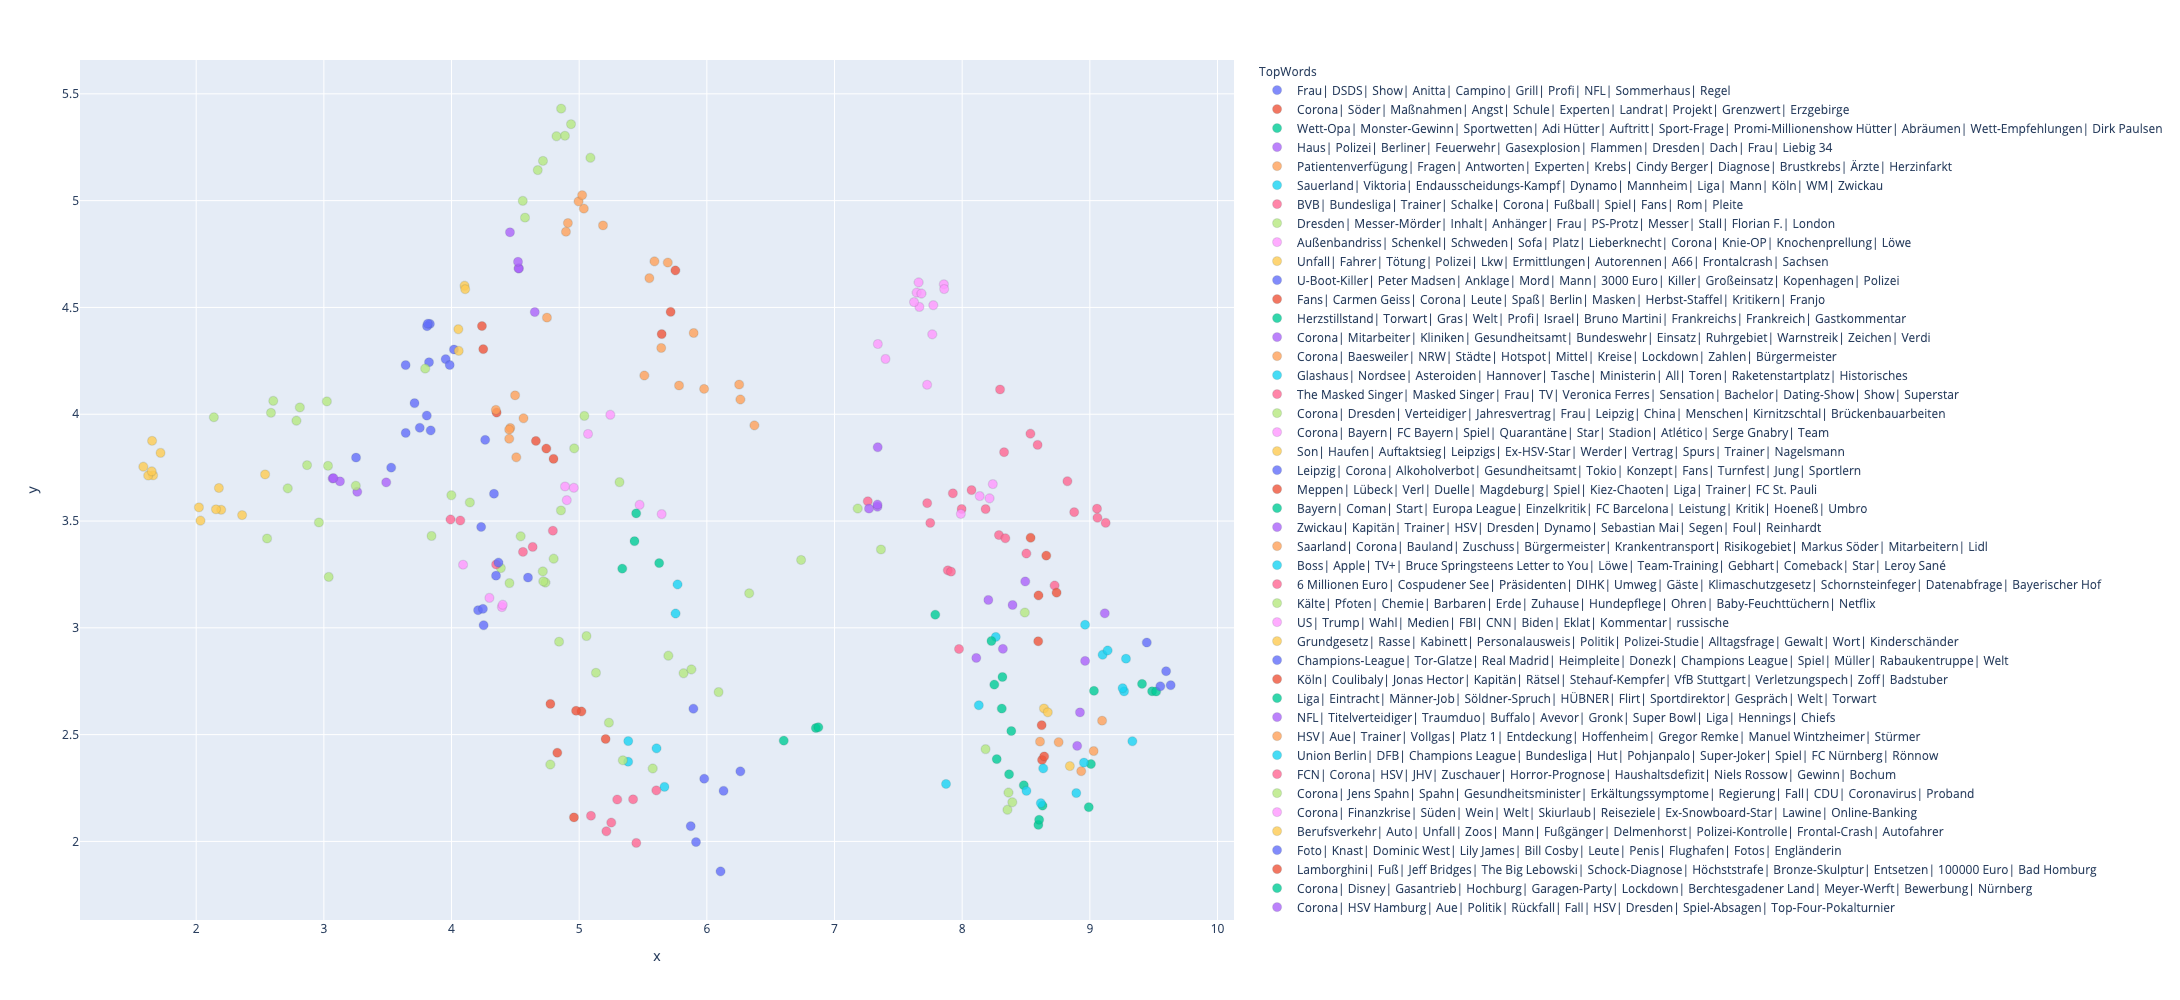

In [273]:
fig = px.scatter(results_a, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords","topic_number"], color="TopWords",opacity=0.8)

fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()

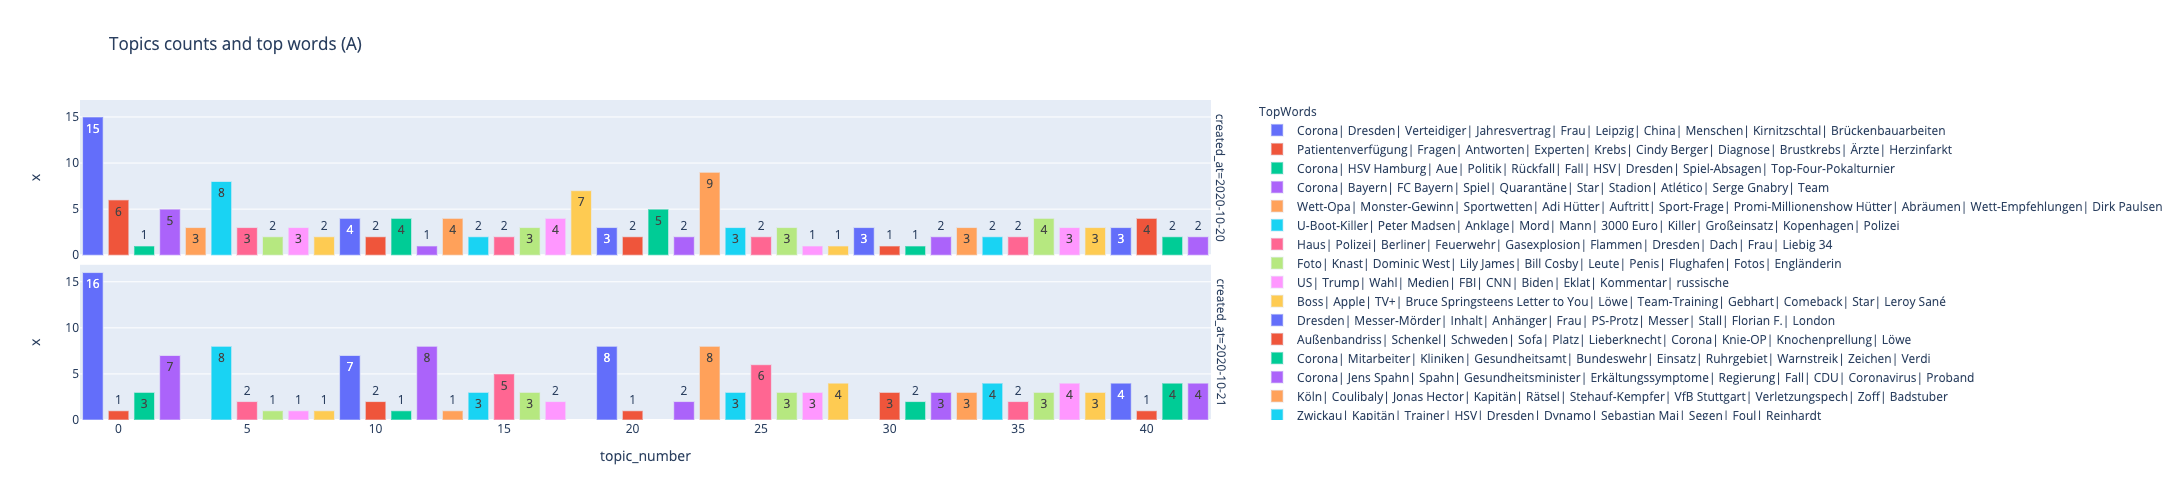

In [276]:

fig = px.bar(results_a.groupby(["created_at",'topic_number',"TopWords"]).count().reset_index(), x="topic_number", y="x", color="TopWords",hover_name="TopWords",
         title="Topics counts and top words (A)",facet_row="created_at",text="x")
fig.update_layout(
     height=500)

fig.show()

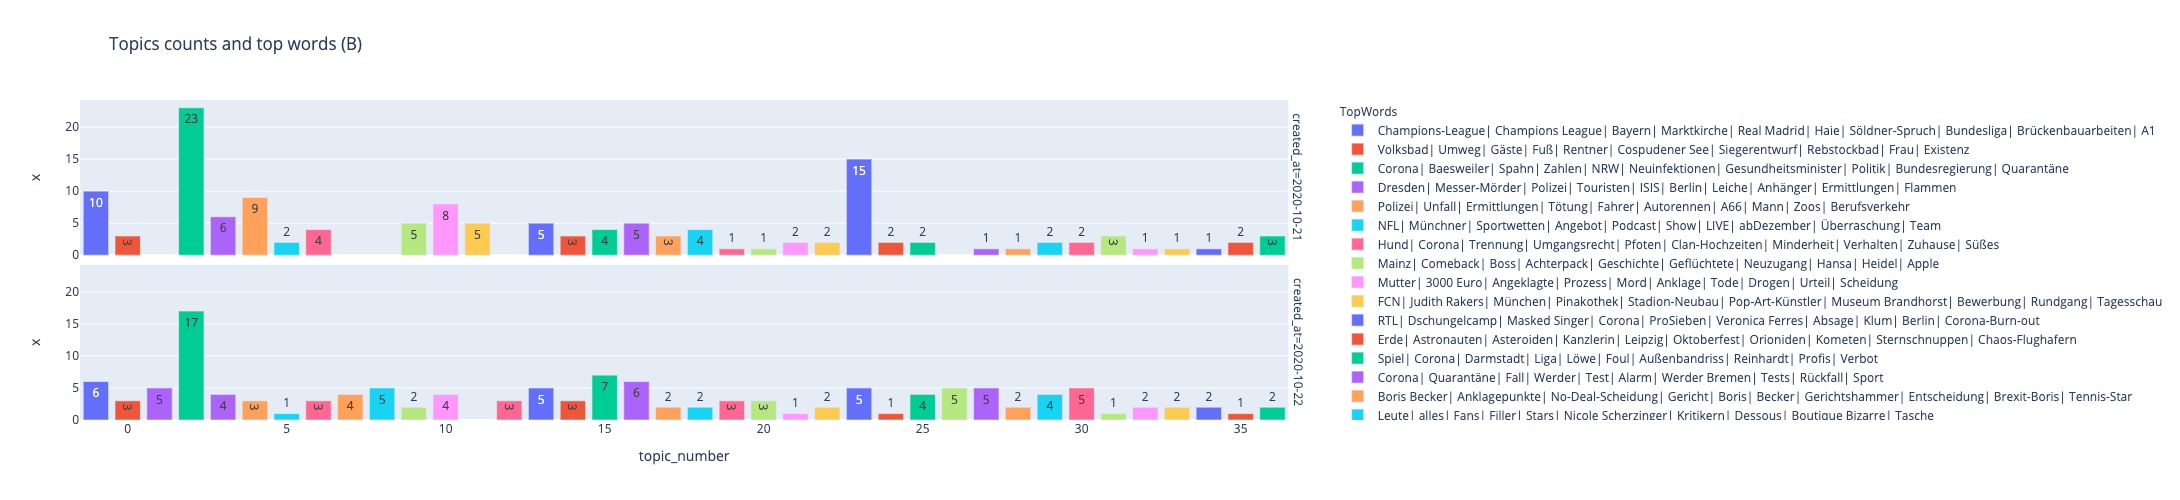

In [270]:
results_b=pd.merge(docs_df_b,cluster_labels_google_b.reset_index(),left_on="topic_number",right_on = "Topic")

fig = px.bar(results_b.groupby(["created_at",'topic_number',"TopWords"]).count().reset_index(), x="topic_number", y="x", color="topic_number",hover_name="TopWords",
         title="Topics counts and top words (B)",facet_row="created_at",text="x")
fig.update_layout(
     height=500)

fig.show()

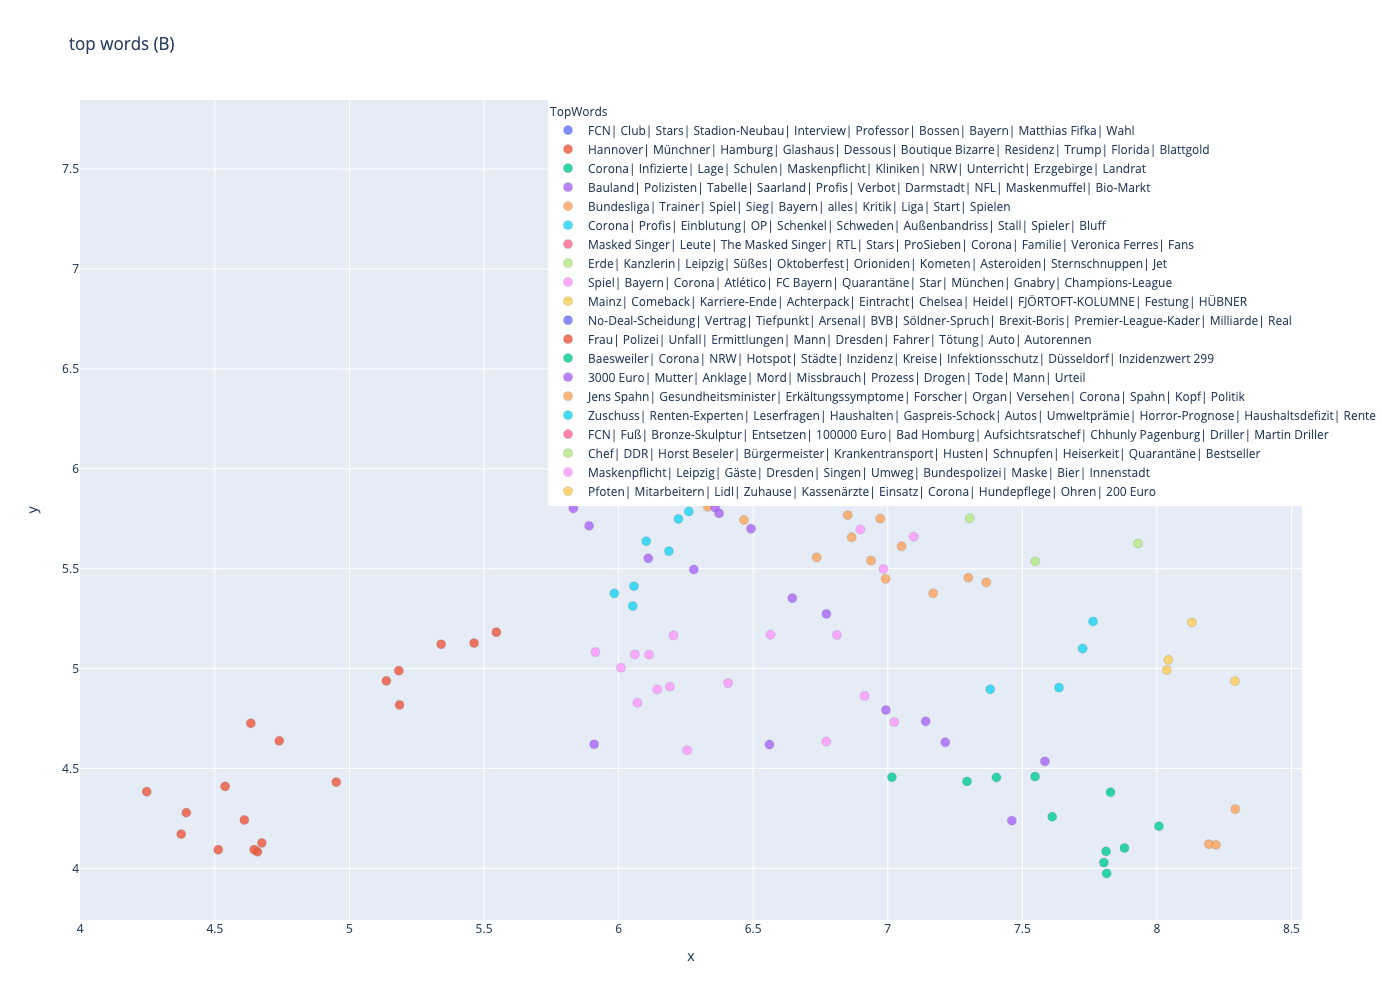

In [239]:

fig = px.scatter(results_b, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords","topic_number"], color="TopWords", title="top words (B)",opacity=0.8)

fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()

In [240]:
cluster_labels_google_a.index.to_list()
data= cdist(np.stack(cluster_labels_google_a.merged_headline_embedding.values),np.stack(cluster_labels_google_b.merged_headline_embedding.values),"cosine")

dist_matrix=pd.DataFrame(data,columns=cluster_labels_google_b.TopWords.to_list(),index=cluster_labels_google_a.TopWords.to_list()).style.highlight_min(color = 'lightgreen',axis = "rows")
dist_matrix

,Bauland| Polizisten| Tabelle| Saarland| Profis| Verbot| Darmstadt| NFL| Maskenmuffel| Bio-Markt,Masked Singer| Leute| The Masked Singer| RTL| Stars| ProSieben| Corona| Familie| Veronica Ferres| Fans,Bundesliga| Trainer| Spiel| Sieg| Bayern| alles| Kritik| Liga| Start| Spielen,Corona| Profis| Einblutung| OP| Schenkel| Schweden| Außenbandriss| Stall| Spieler| Bluff,Spiel| Bayern| Corona| Atlético| FC Bayern| Quarantäne| Star| München| Gnabry| Champions-League,No-Deal-Scheidung| Vertrag| Tiefpunkt| Arsenal| BVB| Söldner-Spruch| Brexit-Boris| Premier-League-Kader| Milliarde| Real,3000 Euro| Mutter| Anklage| Mord| Missbrauch| Prozess| Drogen| Tode| Mann| Urteil,Frau| Polizei| Unfall| Ermittlungen| Mann| Dresden| Fahrer| Tötung| Auto| Autorennen,FCN| Fuß| Bronze-Skulptur| Entsetzen| 100000 Euro| Bad Homburg| Aufsichtsratschef| Chhunly Pagenburg| Driller| Martin Driller,Pfoten| Mitarbeitern| Lidl| Zuhause| Kassenärzte| Einsatz| Corona| Hundepflege| Ohren| 200 Euro,FCN| Club| Stars| Stadion-Neubau| Interview| Professor| Bossen| Bayern| Matthias Fifka| Wahl,Mainz| Comeback| Karriere-Ende| Achterpack| Eintracht| Chelsea| Heidel| FJÖRTOFT-KOLUMNE| Festung| HÜBNER,Chef| DDR| Horst Beseler| Bürgermeister| Krankentransport| Husten| Schnupfen| Heiserkeit| Quarantäne| Bestseller,Zuschuss| Renten-Experten| Leserfragen| Haushalten| Gaspreis-Schock| Autos| Umweltprämie| Horror-Prognose| Haushaltsdefizit| Rente,Maskenpflicht| Leipzig| Gäste| Dresden| Singen| Umweg| Bundespolizei| Maske| Bier| Innenstadt,Erde| Kanzlerin| Leipzig| Süßes| Oktoberfest| Orioniden| Kometen| Asteroiden| Sternschnuppen| Jet,Hannover| Münchner| Hamburg| Glashaus| Dessous| Boutique Bizarre| Residenz| Trump| Florida| Blattgold,Corona| Infizierte| Lage| Schulen| Maskenpflicht| Kliniken| NRW| Unterricht| Erzgebirge| Landrat,Baesweiler| Corona| NRW| Hotspot| Städte| Inzidenz| Kreise| Infektionsschutz| Düsseldorf| Inzidenzwert 299,Jens Spahn| Gesundheitsminister| Erkältungssymptome| Forscher| Organ| Versehen| Corona| Spahn| Kopf| Politik
Köln| Clan-Hochzeiten| Minderheit| Verhalten| DFB| Achterpack| Stall| Spiel| Rönnow| Kobel,0.568034,0.506927,0.400472,0.290908,0.501487,0.602332,0.600365,0.599437,0.476547,0.655989,0.498557,0.431251,0.694814,0.733385,0.533249,0.689329,0.657149,0.678193,0.674663,0.751209
Unfall| Mann| Tötung| Polizei| Ermittlungen| 3000 Euro| Frau| Mutter| Staatsanwaltschaft| Mord,0.624520,0.630585,0.678007,0.704530,0.608185,0.773943,0.224029,0.303096,0.740190,0.655282,0.722503,0.693251,0.623994,0.793644,0.675114,0.651595,0.700592,0.757890,0.731241,0.796567
Corona| Jens Spahn| NRW| Baesweiler| Gesundheitsminister| Spahn| Regierung| Politik| Alarm| Antworten,0.421928,0.597640,0.574509,0.553274,0.575415,0.671211,0.674476,0.681430,0.661365,0.515446,0.577432,0.591179,0.529713,0.551282,0.640877,0.688018,0.707651,0.427360,0.540345,0.421647
Maskenpflicht| Schulen| Leipzig| Filialen| Douglas| Flammen| Leiche| Dresden| Singen| Pfoten,0.460685,0.718191,0.800798,0.708640,0.727067,0.837914,0.712765,0.585328,0.701019,0.538394,0.686837,0.764640,0.560706,0.685785,0.308411,0.616906,0.577639,0.532392,0.632873,0.777067
Leute| Masked Singer| The Masked Singer| Knast| RTL| ProSieben| Veronica Ferres| Fear| the Walking Dead| Prime,0.537019,0.186428,0.545195,0.535433,0.550277,0.628132,0.479422,0.523637,0.608255,0.624608,0.462906,0.516638,0.604648,0.716151,0.399104,0.338172,0.508543,0.642963,0.632575,0.768416
München| Judith Rakers| Boss| Pinakothek| FCN| Münchner| NFL| DDR| Horst Beseler| Stadion-Neubau,0.537644,0.462637,0.510093,0.480920,0.544883,0.510464,0.607512,0.595818,0.447243,0.740041,0.308738,0.395361,0.538080,0.593875,0.531922,0.518584,0.444387,0.721011,0.647751,0.725509
Corona| Aue| Politik| Süßes| Umweg| Gäste| Bundespolizei| Rückfall| Fall| Brückenbauarbeiten,0.682374,0.562538,0.597625,0.591068,0.535820,0.786200,0.717958,0.673234,0.627538,0.716763,0.515720,0.630001,0.752537,0.677111,0.277652,0.601241,0.644349,0.621508,0.668644,0.841611
Champions-League| Real Madrid| Cham

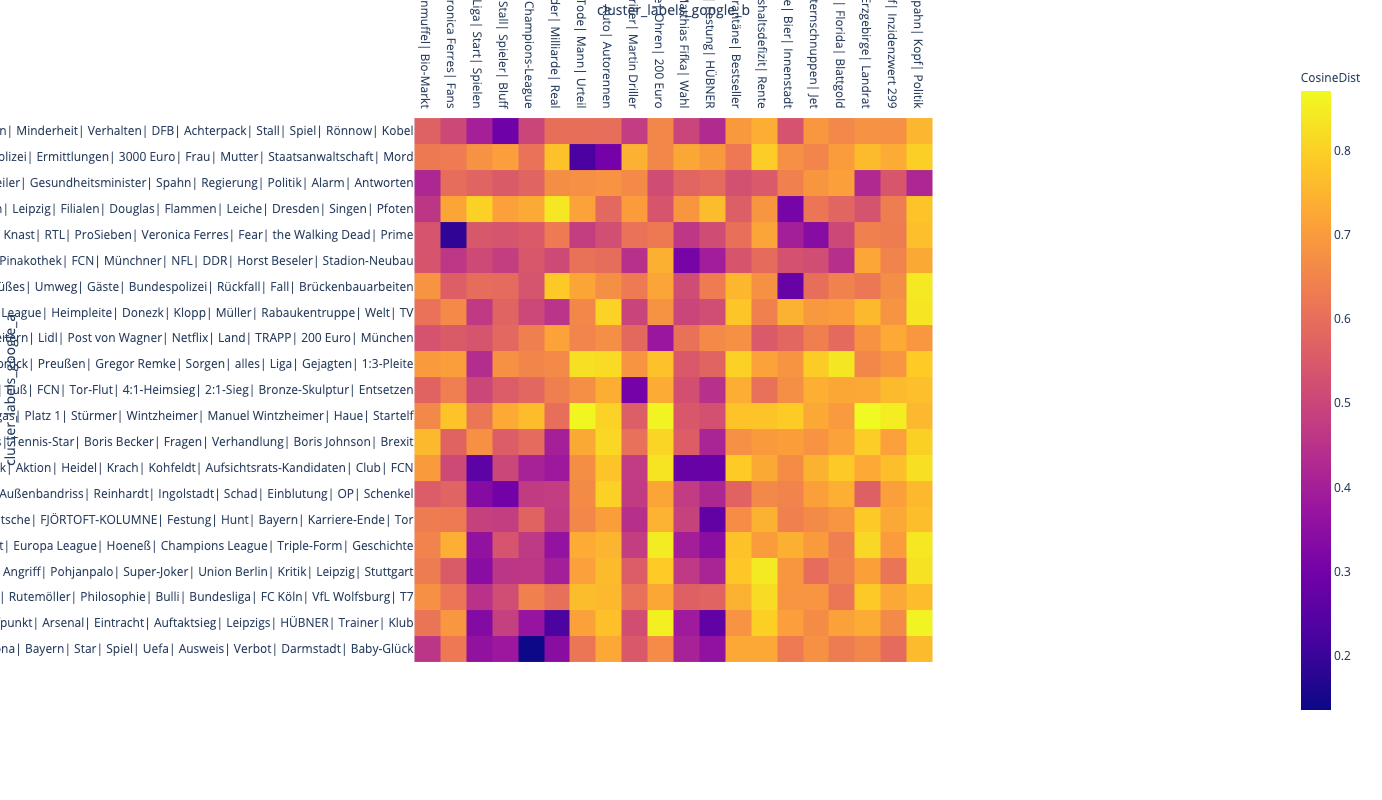

In [255]:
import plotly.express as px
fig = px.imshow(data,
                labels=dict(x="cluster_labels_google_b", y="cluster_labels_google_a", color="CosineDist"),
                x=cluster_labels_google_b.TopWords.to_list(),
                y=cluster_labels_google_a.TopWords.to_list()
               )
fig.update_xaxes(side="top")
fig.update_layout(height=800)

fig.show()

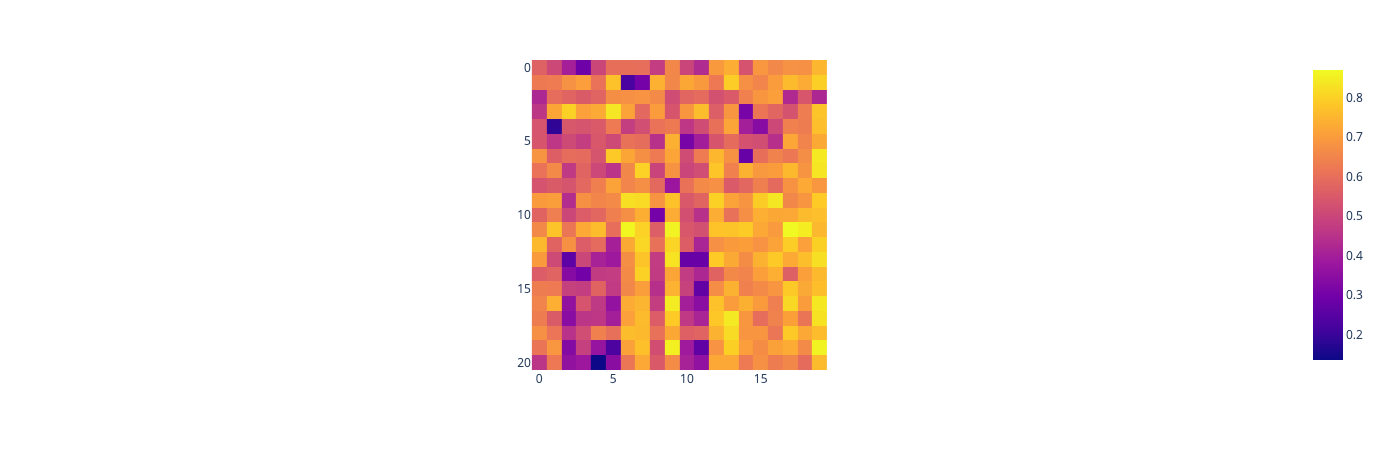

In [256]:

fig = px.imshow(cdist(np.stack(cluster_labels_google_a.merged_headline_embedding.values),np.stack(cluster_labels_google_b.merged_headline_embedding.values),"cosine"))
fig.show()